In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from denoising_diffusion_pytorch import Unet
#from diffusers import DDIMScheduler,DDPMScheduler
import os
from unet import UNet

In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS
else:
    device = torch.device("cpu")  # Fallback to CPU

In [20]:
class catDataset(Dataset):
    def __init__(self, img_dir, second_img_dir):
        self.img_dir = img_dir
        self.img_names = []

        for filename in os.listdir(img_dir):
            file_path = os.path.join(img_dir, filename)
            if os.path.isfile(file_path):
                self.img_names.append(file_path)
        
        for filename in os.listdir(second_img_dir):
            file_path = os.path.join(second_img_dir, filename)
            if os.path.isfile(file_path):
                self.img_names.append(file_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        image = read_image(self.img_names[idx])
        image = image.to(torch.float32)/255.0
        return image


In [21]:
def get_model_size(model):
    return sum(p.numel() for p in model.parameters())


In [22]:
ds=catDataset("./cats","./mycat_64x64")
batch_size = 64
train_dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [23]:
class DDPMScheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [24]:
total_timesteps = 1000
sch = DDPMScheduler(total_timesteps)
#sch.set_timesteps(50)
# Inference and training are totally seperate
# train always is t -> t-1 
#sch.step(img1,25,)
# Use gaussian noise 
# img, gaussian, timestep
# sch.add_noise(img1,torch.randn_like(img1),torch.tensor(999))
# plt.imshow can work with floats just complains a bit
# .permute(1, 2, 0)

In [25]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        # Initialize EMA parameters with the same values as model parameters
        self.ema_params = {name: param.clone().detach() for name, param in model.named_parameters()}

    def update(self):
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                self.ema_params[name] = self.decay * self.ema_params[name] + (1 - self.decay) * param

    def apply(self):
        for name, param in self.model.named_parameters():
            param.data = self.ema_params[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            param.data = self.ema_params[name]


In [26]:
def train_loop(dataloader, model, loss_fn, optimizer, ema):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X) in enumerate(dataloader):
        x_0 = X.to(device)
        curr_bs = X.shape[0]
        t = torch.randint(0,total_timesteps,(curr_bs,))
        noise = torch.randn_like(x_0,requires_grad=False)
        a = sch.alpha[t].view(curr_bs,1,1,1).to(device)
        x = (torch.sqrt(a)*x_0) + (torch.sqrt(1-a)*noise)
        t=t.to(device)

        pred = model(x,t)
        loss = loss_fn(noise,pred)

        # Backpropagation
        loss.backward()
        optimizer.step()
        ema.update()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            #print(torch.mps.current_allocated_memory()/1e9)


In [27]:
losf = nn.MSELoss()
model = Unet(
    dim=64,
    channels=3,
    dim_mults=[1,2,4,8],
    full_attn=None,
    flash_attn=True,
    attn_heads=2,
    attn_dim_head=4
).to(device)
ema = EMA(model,decay=0.995)
print(f"Model has {get_model_size(model)} parameters")
epochs = 1
opt = torch.optim.AdamW(model.parameters(),2e-5)
for i in range(epochs):
    print(f"Epoch {i}")
    train_loop(train_dataloader,model,losf,opt,ema)
    print(torch.mps.current_allocated_memory()/1e9)

Model has 34750531 parameters
Epoch 0
loss: 1.088195  [   64/29854]
loss: 0.217424  [ 6464/29854]
loss: 0.094745  [12864/29854]
loss: 0.080740  [19264/29854]
loss: 0.049879  [25664/29854]
1.27644544


In [28]:
print(torch.mps.current_allocated_memory()/1e9)

1.27644544


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3002107..3.1691687].


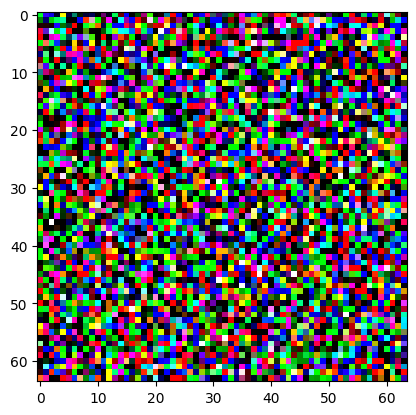

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1789876..1.0816302].


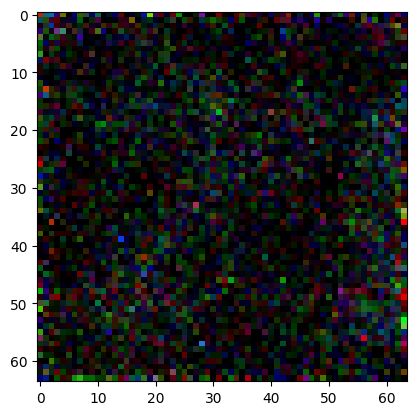

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1873691..1.0264448].


tensor([[[[ 0.2496,  0.6032, -0.0506,  ..., -0.4919, -0.3038,  0.1106],
          [ 0.2687,  0.1270,  0.2616,  ...,  0.4985, -0.4707, -0.0697],
          [-0.5459,  0.1520, -0.3684,  ..., -0.6002,  0.5943, -0.1078],
          ...,
          [ 0.4025, -0.4760,  0.3597,  ...,  0.5180, -0.2528,  0.2675],
          [-0.5636,  0.7201,  0.6223,  ...,  0.1688,  0.5312, -0.2557],
          [-0.4033, -0.1294,  0.3149,  ...,  0.0867,  0.0169,  0.2389]],

         [[ 0.1379,  0.2317, -0.6292,  ...,  0.0935, -0.0929,  0.1848],
          [ 0.4569,  0.2266,  0.1933,  ..., -0.3669,  0.7162,  0.3625],
          [ 0.6394, -0.8859,  0.9017,  ...,  0.0670,  0.0183, -0.6130],
          ...,
          [ 0.0658,  0.2565, -0.1735,  ..., -0.0734, -0.4758,  0.4506],
          [-0.3801, -0.7210, -0.4413,  ...,  0.2665,  0.7569, -0.4860],
          [ 0.3431,  0.7415,  0.0685,  ...,  0.1001,  0.2186, -0.2552]],

         [[-0.2538, -0.1630,  0.2313,  ..., -0.5294,  0.0815,  0.1994],
          [-0.5358, -0.0283, -

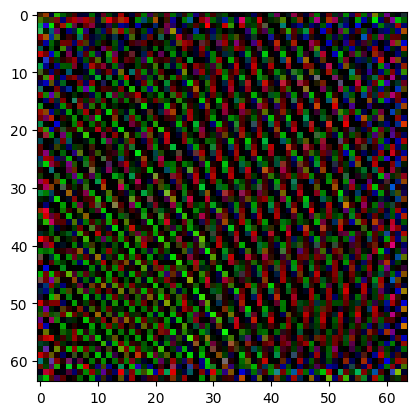

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.236561..0.96162426].


tensor([[[[ 0.2300,  0.1312, -0.1218,  ...,  0.1509,  0.0462, -0.2671],
          [-0.1387, -0.6880, -0.4960,  ..., -0.0377,  0.8721, -0.0672],
          [-0.2114,  0.1285,  0.0666,  ..., -0.4758, -0.3742,  0.2092],
          ...,
          [ 0.0840,  0.6498,  0.2386,  ...,  0.0542, -0.5300,  0.2236],
          [-0.7014, -0.1198,  0.3359,  ...,  0.9616, -0.3683,  0.1649],
          [-0.4801, -0.2919, -0.1685,  ..., -0.2507, -0.2052,  0.3965]],

         [[-0.6232,  0.5183,  0.5484,  ...,  0.0147, -0.4453, -0.0941],
          [-0.0627, -0.0424,  0.7387,  ...,  0.1918,  0.1832,  0.0016],
          [ 0.0016, -1.0094, -0.2870,  ...,  0.0619,  0.5448, -0.7307],
          ...,
          [ 0.2148, -0.5028, -0.8618,  ..., -0.0772, -0.4945,  0.5363],
          [-0.3060,  0.6333,  0.2855,  ..., -0.0962, -0.1742, -0.4329],
          [-0.1305, -0.4936,  0.1184,  ...,  0.2115,  0.1228,  0.0727]],

         [[ 0.1914,  0.3509, -0.1796,  ..., -0.6262, -0.0294,  0.5163],
          [ 0.1775,  0.3976, -

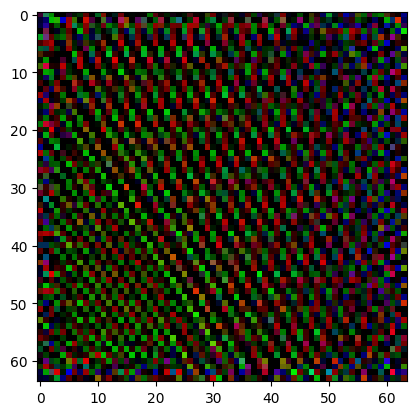

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2161847..1.0513074].


tensor([[[[-0.1388,  0.1714,  0.1512,  ...,  0.0839,  0.0446, -0.3154],
          [ 0.1236, -0.6971,  0.1990,  ...,  0.2689,  0.6023, -0.7076],
          [ 0.3633, -0.5003, -0.4425,  ...,  0.6586, -0.3641,  0.1530],
          ...,
          [ 0.3080,  0.4237, -0.8200,  ...,  0.9540,  0.0637, -0.0219],
          [ 0.2086,  0.7814, -1.1854,  ..., -0.3695,  0.4255,  0.1166],
          [-0.1322, -0.5325,  0.1491,  ..., -0.6824, -0.1576,  0.1377]],

         [[-0.4717,  0.1530,  0.2322,  ..., -0.2805,  0.2608,  0.3092],
          [-0.0418, -0.3008, -0.4023,  ...,  0.5062, -0.7038, -0.2027],
          [-0.6603,  0.3374,  0.3296,  ..., -0.4943, -0.4393,  0.8946],
          ...,
          [-0.1717, -0.0593,  0.0798,  ..., -0.0183,  0.0054, -0.4737],
          [-0.3906, -0.1634,  0.5567,  ...,  0.5425,  0.3532, -0.4326],
          [-0.0967, -0.4718, -0.4340,  ..., -0.3595,  0.1029, -0.0108]],

         [[-0.3434,  0.3739, -0.1637,  ...,  0.1224, -0.1443, -0.1227],
          [ 0.2304, -0.2180,  

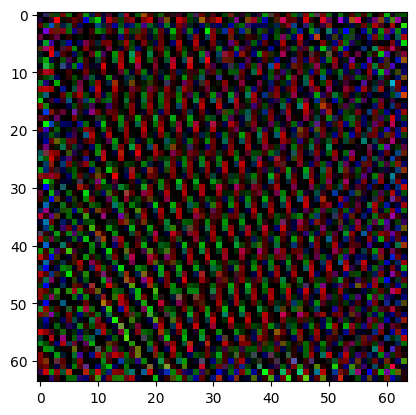

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2715592..1.0731399].


tensor([[[[ 0.5519, -0.4911,  0.0085,  ...,  0.2101,  0.5398, -0.3013],
          [ 0.5170,  0.7864, -0.4893,  ..., -0.7489, -0.0432,  0.6093],
          [ 0.7050, -0.4287, -0.1560,  ..., -0.6552, -0.7307,  0.6307],
          ...,
          [-0.1223, -0.3327, -0.6367,  ...,  0.5844,  0.4710, -0.3953],
          [ 0.0665,  0.3030,  0.6119,  ...,  0.8609, -0.9327,  0.2661],
          [-0.3055, -0.1333, -0.0057,  ...,  0.0731, -0.3755,  0.3599]],

         [[-0.0577,  0.2106,  0.1041,  ...,  0.0634,  0.2174, -0.0027],
          [ 0.1771, -0.6665, -0.7591,  ...,  0.4731, -0.2724, -0.1225],
          [-0.2842,  0.8628,  0.5398,  ...,  0.0902, -0.0810,  0.4796],
          ...,
          [ 0.1400,  0.0674,  0.2617,  ..., -0.3678,  0.2998, -0.4273],
          [ 0.3446,  0.1160, -0.8903,  ..., -0.3433, -0.5113,  0.3208],
          [-0.4275, -0.3319,  0.8164,  ...,  0.1178, -0.5080,  0.3542]],

         [[-0.2286, -0.2389, -0.0829,  ...,  0.4099, -0.1631,  0.4183],
          [-0.0258, -0.0422,  

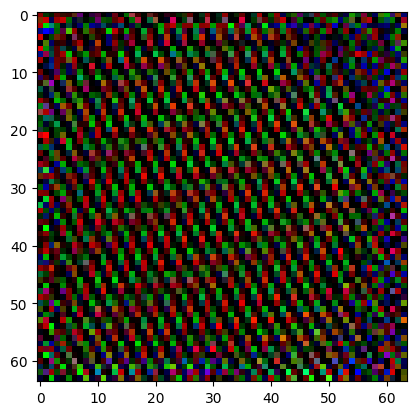

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2814524..1.1052983].


tensor([[[[ 0.2335,  0.0289, -0.7501,  ...,  0.2952,  0.2540, -0.4747],
          [ 0.2595,  0.8948,  0.7106,  ..., -0.3898,  1.0421, -0.9051],
          [ 0.3432,  0.3328,  0.7721,  ...,  0.0801, -0.4671,  0.7605],
          ...,
          [-0.1192, -0.7986, -0.1228,  ..., -0.3839,  0.3387, -0.2450],
          [-0.0776,  0.5938,  0.1091,  ...,  0.1803, -0.6157,  0.0102],
          [-0.2247,  0.4806,  0.5254,  ..., -0.0777,  0.3292,  0.3203]],

         [[-0.4588,  0.1338,  0.3088,  ..., -0.0204, -0.2885,  0.5966],
          [-0.6107, -0.5755, -0.8010,  ...,  0.4641, -0.9214, -0.2153],
          [-0.5106, -0.1994, -0.3628,  ..., -0.4281,  0.2583,  0.1358],
          ...,
          [ 0.2179,  0.4649, -0.2706,  ...,  0.1961,  0.6233, -0.0933],
          [ 0.2322, -0.5788, -0.4579,  ..., -0.2060,  0.5097, -0.4210],
          [ 0.1796,  0.1640,  0.2048,  ..., -0.0810, -0.3686, -0.0137]],

         [[ 0.1326,  0.3479, -0.3118,  ...,  0.6588,  0.0615, -0.1217],
          [ 0.0601,  0.1965, -

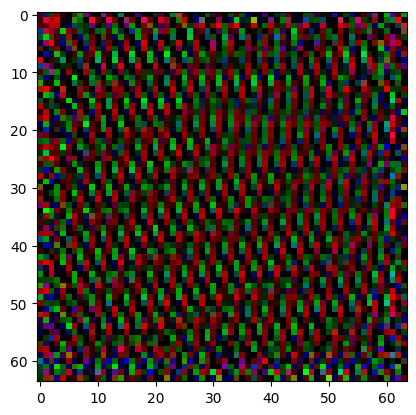

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.306413..1.132929].


tensor([[[[ 3.1332e-02,  6.8769e-02,  3.1216e-01,  ...,  1.3002e-01,
           -3.9462e-01, -4.1885e-02],
          [-4.4392e-02, -3.6042e-01, -3.1458e-01,  ...,  7.2937e-01,
           -1.0144e+00, -2.6239e-01],
          [-7.9938e-01, -2.4246e-01, -2.0914e-01,  ...,  5.9742e-01,
            2.7745e-01,  4.6404e-01],
          ...,
          [-2.0245e-01, -4.4275e-01, -3.2416e-01,  ...,  4.7770e-01,
           -5.0234e-01,  2.3744e-01],
          [ 4.1521e-01,  5.2459e-01, -7.8833e-01,  ..., -1.6528e-03,
            7.0532e-01, -4.6933e-01],
          [-4.0120e-02,  8.1625e-04, -2.1173e-01,  ..., -3.0657e-01,
           -2.1342e-02,  3.9064e-01]],

         [[ 4.7466e-01,  3.6484e-01, -3.7811e-01,  ..., -3.7330e-02,
            7.4340e-01,  3.9760e-01],
          [ 1.5609e-02,  6.1579e-01,  9.6334e-01,  ..., -6.4658e-01,
            5.2663e-02,  6.2937e-01],
          [ 7.5928e-01, -8.7382e-01,  4.7967e-01,  ...,  3.8903e-01,
           -1.8957e-01,  6.0148e-01],
          ...,
     

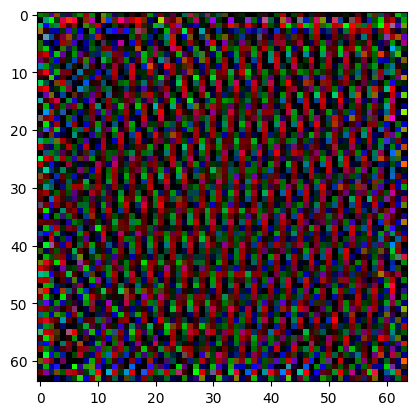

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2817575..1.2874937].


tensor([[[[ 0.4076,  0.1645, -0.1001,  ...,  0.5310,  0.7224,  0.2450],
          [-0.1387,  0.8534, -0.6985,  ...,  0.7713,  0.8576, -0.5305],
          [ 0.9375,  0.3175,  0.0317,  ..., -0.6554,  0.4624,  0.4324],
          ...,
          [ 0.0880, -0.0160,  0.0844,  ...,  0.9234,  0.0165, -0.9279],
          [-0.2919,  1.0334, -0.7756,  ..., -0.6901,  0.9687, -0.4319],
          [-0.0757, -0.4670, -0.0617,  ..., -0.1980,  0.2222,  0.3248]],

         [[-0.4719,  0.2159,  0.6232,  ..., -0.0054,  0.0179,  0.4903],
          [ 0.1166, -0.3235,  0.7618,  ..., -0.5612, -0.1226, -0.2687],
          [ 0.0335,  1.0645, -0.8297,  ...,  0.6308,  0.4118,  0.5218],
          ...,
          [-0.0836,  0.3620,  0.0950,  ...,  0.8399, -0.0464, -0.7653],
          [ 0.1509, -0.2847,  0.3565,  ...,  0.3112,  0.0109,  0.1846],
          [-0.0436,  0.2023,  0.5747,  ...,  0.3523,  0.3538, -0.0065]],

         [[-0.3672,  0.0942, -0.1277,  ...,  0.3019,  0.2981,  0.4098],
          [ 0.7457, -0.1692,  

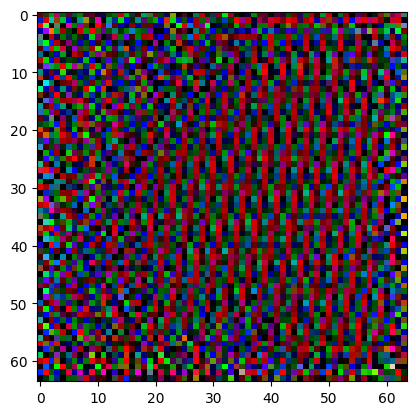

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2058796..1.4307863].


tensor([[[[ 4.0849e-02,  4.8958e-01, -1.8646e-01,  ...,  3.8993e-02,
            1.2456e-01, -1.5323e-02],
          [ 2.9376e-01,  1.0638e+00,  7.8024e-01,  ..., -1.5701e-01,
           -8.9070e-01,  5.5970e-01],
          [ 8.6721e-01,  9.4737e-01,  7.2948e-01,  ...,  7.0394e-01,
            5.2751e-01, -2.2892e-01],
          ...,
          [ 4.4557e-01,  9.3911e-01, -6.1072e-01,  ...,  2.1706e-01,
            7.1737e-02,  9.1720e-01],
          [ 7.3021e-01,  1.0775e+00,  3.4733e-01,  ...,  1.1273e+00,
           -1.6316e-01,  5.5567e-01],
          [-2.3024e-01,  5.1758e-02,  4.5588e-01,  ...,  1.7906e-01,
           -9.9507e-02,  2.8424e-02]],

         [[ 1.0901e-01, -1.5883e-02,  2.0779e-01,  ...,  7.1285e-01,
            2.4965e-01,  2.6764e-01],
          [ 5.3161e-01, -5.4592e-01, -7.9693e-01,  ..., -2.5710e-01,
            4.4469e-01,  3.0145e-01],
          [-2.6897e-02,  7.8270e-01,  6.6899e-01,  ..., -4.3841e-01,
           -1.5523e-01,  8.8279e-01],
          ...,
     

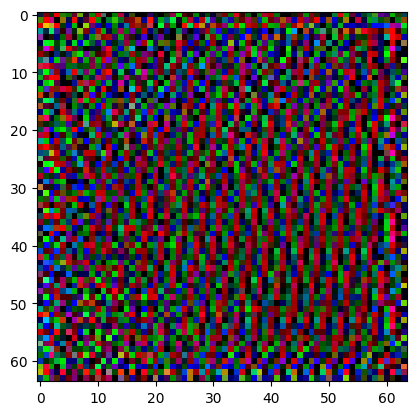

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2136325..1.3875256].


tensor([[[[ 0.2799,  0.2747, -0.2732,  ...,  0.7100,  0.6498, -0.2054],
          [ 0.0728,  1.0024,  0.5211,  ...,  0.3258,  0.3105,  0.1565],
          [ 0.6227,  0.9811,  1.0069,  ..., -0.4537, -0.8269,  0.5574],
          ...,
          [-0.1987,  0.0660, -0.1195,  ...,  0.5477,  0.6823, -0.0711],
          [ 0.2548,  0.1943,  1.2553,  ..., -0.4458,  0.7736, -0.4541],
          [ 0.2598,  0.0751,  0.3332,  ...,  0.2883,  0.3105,  0.2216]],

         [[ 0.1965, -0.1216, -0.4532,  ...,  0.2802,  0.1376,  0.1690],
          [-0.1435, -0.2046, -0.6987,  ..., -0.0379, -0.5561, -0.0667],
          [-0.5372, -0.1803, -0.0069,  ...,  0.0502,  0.2592,  0.1593],
          ...,
          [ 0.6363, -0.0827,  0.1962,  ...,  0.0773, -0.1255,  0.3292],
          [ 0.6421, -0.3955, -0.4408,  ..., -0.0866, -0.0747, -0.3977],
          [ 0.1820,  0.1051, -0.3049,  ...,  0.2880,  0.3262,  0.0460]],

         [[-0.1707, -0.1794, -0.1498,  ...,  0.2619, -0.1090,  0.3996],
          [-0.2009,  0.2882,  

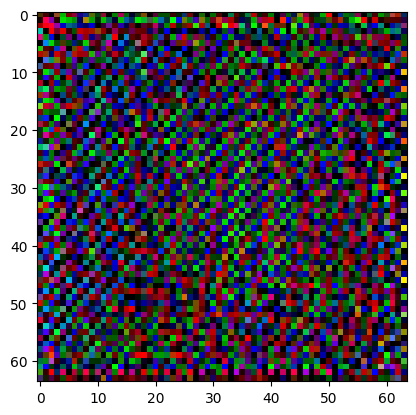

In [29]:
images = []
with torch.no_grad():
    # Initialize z
    z = torch.randn_like(ds[0]).to(device).unsqueeze(0)
    
    # Loop through timesteps in reverse order
    for t in reversed(range(1, total_timesteps)):
        unnouse = model(z,torch.tensor(t).unsqueeze(0).to(device))
        z = z-model(z,torch.tensor(t).unsqueeze(0).to(device))
        if(t==999):
            x = z.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            plt.imshow(unnouse.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
            plt.show()
            plt.imshow(z.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
            plt.show()
        if(t%100 == 0):
            print(z)
            x = z.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            plt.imshow(x)
            plt.show()

In [30]:
torch.mps.current_allocated_memory()/1e9

1.2762944